# Intervening on a model

A common pattern is for a researcher to train a model to perform some task, and then ask something like: what if I did that again, but added a force field that interfered with the model's behaviour on some randomly-chosen trials? 

One of the most powerful features of Feedbax is the ability to modify models and tasks with *interventions*, in only a few lines of code.

We'll demonstrate on a model trained just like we trained it in Example 0.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax 

from feedbax.xabdeef import point_mass_nn_simple_reaches

seed = 1234
key = jax.random.PRNGKey(seed)
key_init, key_train, key_eval = jax.random.split(key, 3)

context = point_mass_nn_simple_reaches(key=key_init)

task = context.task  # Shorthand

model, train_history = context.train(
    n_batches=1000,
    batch_size=250,
    learning_rate=1e-2,
    log_step=500,
    key=key_train,
)

/home/mll/.miniforge3/envs/fx/lib/python3.11/site-packages/diffrax/adjoint.py:665: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  _loop_backsolve.defvjp(_loop_backsolve_fwd, _loop_backsolve_bwd)


compile:   0%|          | 0/1 [00:00<?, ?it/s]

Training step compiled.
Validation step compiled.


train batch:   0%|          | 0/1000 [00:00<?, ?it/s]


Training iteration: 0
	training loss: 2.41e+01
	validation loss: 5.39e+00

Training iteration: 500
	training loss: 4.22e-03
	validation loss: 7.78e-04


(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: title={'center': 'Position'}, xlabel='$x$', ylabel='$y$'>,
        <Axes: title={'center': 'Velocity'}, xlabel='$\\dot x$', ylabel='$\\dot y$'>,
        <Axes: title={'center': 'Control force'}, xlabel='$\\mathrm{f}_x$', ylabel='$\\mathrm{f}_y$'>],
       dtype=object))

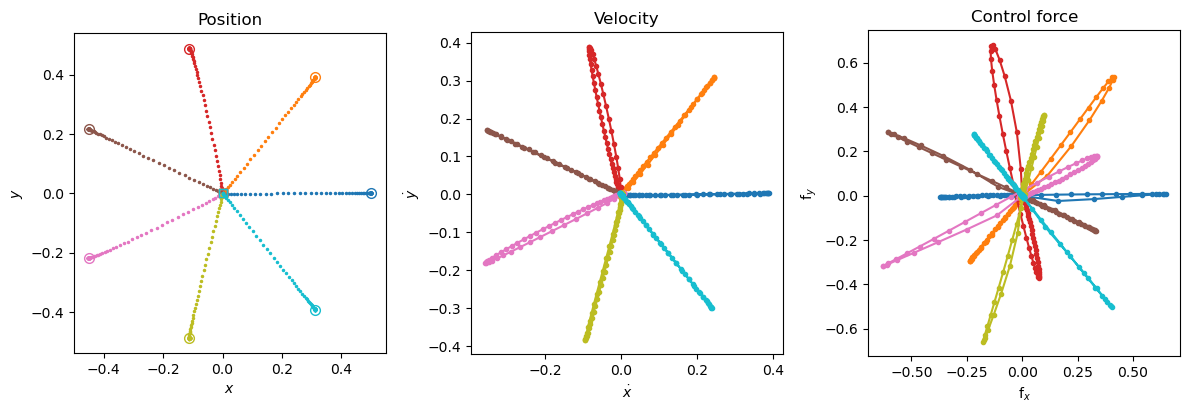

In [3]:
from feedbax.plot import plot_reach_trajectories

states = task.eval(model, key=key_eval)

plot_reach_trajectories(states, trial_specs=task.validation_trials)

## Adding a force field

Those reaches look pretty straight. But the network never had to deal with other forces pushing on the point mass. 

What happens if we add a constant curl force field? Let's make it clockwise. That means that the faster the point mass is moving in some direction, the harder it'll be pushed to the right of the direction it's moving.

In [4]:
from feedbax.intervene import add_intervenor, CurlField 

model_curl = add_intervenor(
    model, 
    CurlField.with_params(amplitude=-0.5),  # negative -> clockwise
    where=lambda m: m.step.mechanics,
)

We have to specify that the curl field should specifically be added to `model.step.mechanics`, since that is the relevant scope for this kind of intervention. 

Now we can see the effect of this curl field on the reaches:

(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: title={'center': 'Position'}, xlabel='$x$', ylabel='$y$'>,
        <Axes: title={'center': 'Velocity'}, xlabel='$\\dot x$', ylabel='$\\dot y$'>,
        <Axes: title={'center': 'Control force'}, xlabel='$\\mathrm{f}_x$', ylabel='$\\mathrm{f}_y$'>],
       dtype=object))

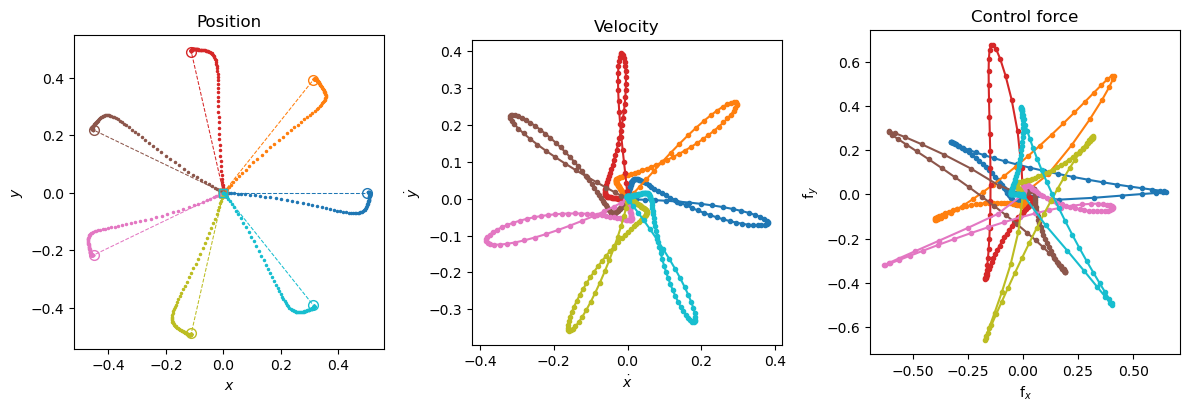

In [5]:
plot_reach_trajectories(
    task.eval(model_curl, key=key_eval), 
    trial_specs=task.validation_trials,
    straight_guides=True,  # Show dashed lines for "ideal" straight reaches
)

## Scheduling a force field

By adding an intervention using `add_intervenor`, we obtained an updated model that always applied a curl force field at all times, and on every trial. 

Often, we want an intervention to only appear on some trials, or for the parameters of the intervention to change between or within trials. In that case, we have to modify `task` as well, since it is in control of the parameters which systematically vary between trials.  

For this, we use `schedule_intervenor`, which both adds the intervention to the model, and modifies the task to include per-trial parameters for the 

In [22]:
from feedbax.intervene import schedule_intervenor

curl_std = 0.5

task_random_curl, model_random_curl = schedule_intervenor(
    task, model, 
    CurlField.with_params(
        amplitude=lambda trial_specs, *, key: curl_std * jax.random.normal(key, shape=(1,)),
    ),
    where=lambda model: model.step.mechanics,
    default_active=False,  
)

(<Figure size 1200x600 with 3 Axes>,
 array([<Axes: title={'center': 'Position'}, xlabel='$x$', ylabel='$y$'>,
        <Axes: title={'center': 'Velocity'}, xlabel='$\\dot x$', ylabel='$\\dot y$'>,
        <Axes: title={'center': 'Control force'}, xlabel='$\\mathrm{f}_x$', ylabel='$\\mathrm{f}_y$'>],
       dtype=object))

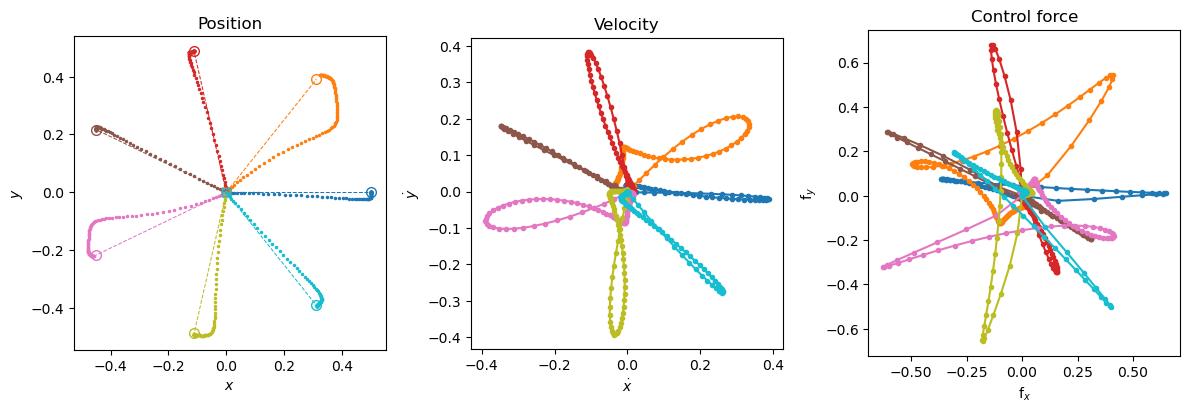

In [23]:
plot_reach_trajectories(
    task_random_curl.eval(model_random_curl, key=key_eval), 
    trial_specs=task.validation_trials,
    straight_guides=True,  # Show dashed lines for "ideal" straight reaches
)